# Sentiment Analysis on IMDb Movie Reviews

**Objective:**  
This notebook implements an end-to-end sentiment classification pipeline using the `nltk` IMDb movie reviews corpus. Steps covered: corpus creation, preprocessing (tokenization, normalization, stop-word removal, lemmatization), TF-IDF vectorization, training two models (Multinomial Naive Bayes, Logistic Regression), and evaluation (classification report + confusion matrix).

Each code cell is followed by an explanation of what it does and why.


## 0) Installing Required Libraries

Before starting with Sentiment Analysis, we need to install the required Python packages.

### Required Packages
- **pandas** → To handle and manipulate the dataset.
- **numpy** → For numerical operations.
- **scikit-learn** → For machine learning models and evaluation metrics.
- **nltk** → For text preprocessing (tokenization, stopwords, lemmatization).
- **seaborn** → For creating attractive plots (class distribution, confusion matrix).
- **matplotlib** → For general visualizations and plots.
- **wordcloud** → To generate WordClouds for positive/negative reviews.

In [1]:
!pip install pandas numpy scikit-learn nltk seaborn matplotlib wordcloud

## 1) Environment & Imports

This cell imports the required libraries and downloads NLTK data. NLTK corpora such as `movie_reviews`, `punkt`, and `stopwords` are used. The cell also imports the scikit-learn tools required for feature extraction, model training and evaluation.


In [5]:
# 1) Environment & Imports
import nltk
import re
import numpy as np
import pandas as pd

from nltk.corpus import stopwords, movie_reviews
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Optional: visualization libs (used later)
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Download required NLTK assets (do once)
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("stopwords")
nltk.download("movie_reviews")
nltk.download("wordnet")
nltk.download("omw-1.4")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## 2) Corpus Creation

This cell loads the `movie_reviews` corpus from NLTK and converts it into a `pandas.DataFrame` with two columns: `review` (string) and `label` (`pos` or `neg`). Converting the corpus to a DataFrame makes subsequent preprocessing and exploration simple.


In [6]:
# 2) Corpus Creation
documents = [(list(movie_reviews.words(fileid)), category)
             for category in movie_reviews.categories()
             for fileid in movie_reviews.fileids(category)]

reviews = []
labels = []
for words, category in documents:
    reviews.append(" ".join(words))  # join token list into a single string
    labels.append(category)

df = pd.DataFrame({"review": reviews, "label": labels})
print("Dataset shape:", df.shape)
df.head(6)


Dataset shape: (2000, 2)


,review,label
0,"plot : two teen couples go to a church party ,...",neg
1,the happy bastard ' s quick movie review damn ...,neg
2,it is movies like these that make a jaded movi...,neg
3,""" quest for camelot "" is warner bros . ' first...",neg
4,synopsis : a mentally unstable man undergoing ...,neg
5,capsule : in 2176 on the planet mars police ta...,neg


## 3) Preprocessing (tokenization, normalization, stop-word removal, lemmatization)

This cell defines a reusable `preprocess_text()` function that:
1. Converts text to lowercase (normalization).  
2. Removes punctuation and numeric characters via regex (keeps only `a-z` and whitespace).  
3. Tokenizes using NLTK's `word_tokenize`.  
4. Removes English stopwords (using NLTK's stopword list).  
5. Lemmatizes tokens with `WordNetLemmatizer`.  

Finally, it produces a new column `clean_review` in the DataFrame.


In [7]:
# 3) Preprocessing

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def preprocess_text(text):
    """
    - lowercase
    - remove punctuation/numbers (keep only a-z and whitespace)
    - tokenize
    - remove stopwords
    - lemmatize
    returns a cleaned string
    """
    # 1) lowercase
    text = text.lower()
    # 2) remove punctuation & numbers (only keep letters and spaces)
    text = re.sub(r"[^a-z\s]", "", text)
    # 3) tokenize
    tokens = word_tokenize(text)
    # 4) stop-word removal + 5) lemmatization
    cleaned_tokens = [lemmatizer.lemmatize(tok) for tok in tokens if tok not in stop_words and len(tok) > 1]
    return " ".join(cleaned_tokens)

# Apply preprocessing (may take a few seconds)
df["clean_review"] = df["review"].apply(preprocess_text)

# Show examples (original vs cleaned)
df[["label", "review", "clean_review"]].head(6)


,label,review,clean_review
0,neg,"plot : two teen couples go to a church party ,...",plot two teen couple go church party drink dri...
1,neg,the happy bastard ' s quick movie review damn ...,happy bastard quick movie review damn yk bug g...
2,neg,it is movies like these that make a jaded movi...,movie like make jaded movie viewer thankful in...
3,neg,""" quest for camelot "" is warner bros . ' first...",quest camelot warner bros first feature length...
4,neg,synopsis : a mentally unstable man undergoing ...,synopsis mentally unstable man undergoing psyc...
5,neg,capsule : in 2176 on the planet mars police ta...,capsule planet mar police taking custody accus...


## 4) Feature Extraction — TF-IDF

Text must be converted to numeric feature vectors before feeding models. The TF-IDF vectorizer computes term-frequency weighted by inverse document frequency to down-weight very common words. `max_features=5000` keeps the 5,000 most frequent features (helps control dimensionality).


In [8]:
# 4) TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)  # limit vocabulary size for speed
X = vectorizer.fit_transform(df["clean_review"])  # sparse matrix (n_samples x n_features)
y = df["label"]

print("TF-IDF matrix shape:", X.shape)
# Optionally inspect top features:
feature_names = vectorizer.get_feature_names_out()
print("Sample features:", feature_names[:20])


TF-IDF matrix shape: (2000, 5000)
Sample features: ['abandon' 'abandoned' 'ability' 'able' 'aboard' 'abraham' 'absence'
 'absent' 'absolute' 'absolutely' 'absurd' 'abuse' 'abyss' 'academy'
 'accent' 'accept' 'acceptable' 'accepts' 'accident' 'accidentally']


## 5) Train / Test Split

This cell splits the dataset into a training set and a test set (`test_size=0.2`) with a fixed random seed (`random_state=42`) for reproducibility. The training set will be used to fit models; the test set will measure final performance.


In [9]:
# 5) Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Train samples:", X_train.shape[0], " Test samples:", X_test.shape[0])


Train samples: 1600  Test samples: 400


## 6) Model 1 — Multinomial Naive Bayes (Baseline)

Multinomial Naive Bayes is a classic baseline for text classification. It assumes feature independence and works well for high-dimensional sparse data (like TF-IDF or counts). This cell trains the NB model, computes predictions on the test set, and prints a classification report plus the confusion matrix.


In [10]:
# 6) Multinomial Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
nb_preds = nb_model.predict(X_test)

# Evaluation
print("Naive Bayes — Accuracy:", accuracy_score(y_test, nb_preds))
print("\nClassification Report:\n", classification_report(y_test, nb_preds))
print("Confusion Matrix:\n", confusion_matrix(y_test, nb_preds))


Naive Bayes — Accuracy: 0.8075

Classification Report:
               precision    recall  f1-score   support

         neg       0.79      0.84      0.81       200
         pos       0.83      0.78      0.80       200

    accuracy                           0.81       400
   macro avg       0.81      0.81      0.81       400
weighted avg       0.81      0.81      0.81       400

Confusion Matrix:
 [[168  32]
 [ 45 155]]


## 7) Model 2 — Logistic Regression

Logistic Regression is a linear classifier that often performs very well on TF-IDF features. The `max_iter` parameter is increased to ensure convergence. This cell trains the model and evaluates it the same way as Naive Bayes for direct comparison.


In [11]:
# 7) Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)

# Evaluation
print("Logistic Regression — Accuracy:", accuracy_score(y_test, lr_preds))
print("\nClassification Report:\n", classification_report(y_test, lr_preds))
print("Confusion Matrix:\n", confusion_matrix(y_test, lr_preds))


Logistic Regression — Accuracy: 0.835

Classification Report:
               precision    recall  f1-score   support

         neg       0.85      0.81      0.83       200
         pos       0.82      0.86      0.84       200

    accuracy                           0.83       400
   macro avg       0.84      0.83      0.83       400
weighted avg       0.84      0.83      0.83       400

Confusion Matrix:
 [[162  38]
 [ 28 172]]


## 8) Optional Visualizations

This cell shows how to:
- draw word clouds for positive/negative review corpora (quick visual of frequent terms),
- plot confusion matrix heatmaps (easier to read than raw arrays),
- compare model accuracies in a bar chart.

Visualizations are optional but helpful for reports/demos.


### 8.1 WordCloud of Positive & Negative Reviews

A **WordCloud** is a visual representation of the most frequently occurring words in text data.  
- Larger words indicate higher frequency.  
- By generating word clouds for **positive** and **negative** reviews separately, we can observe which words dominate in each sentiment class.


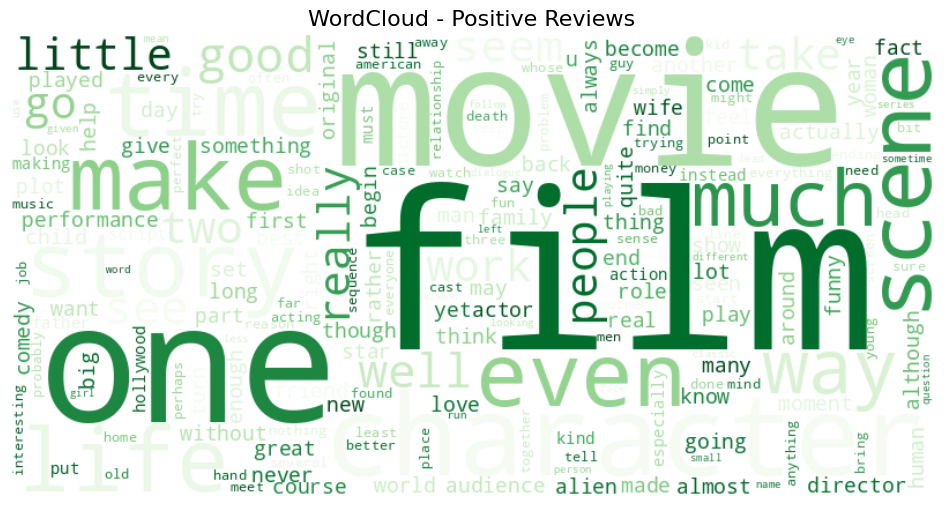

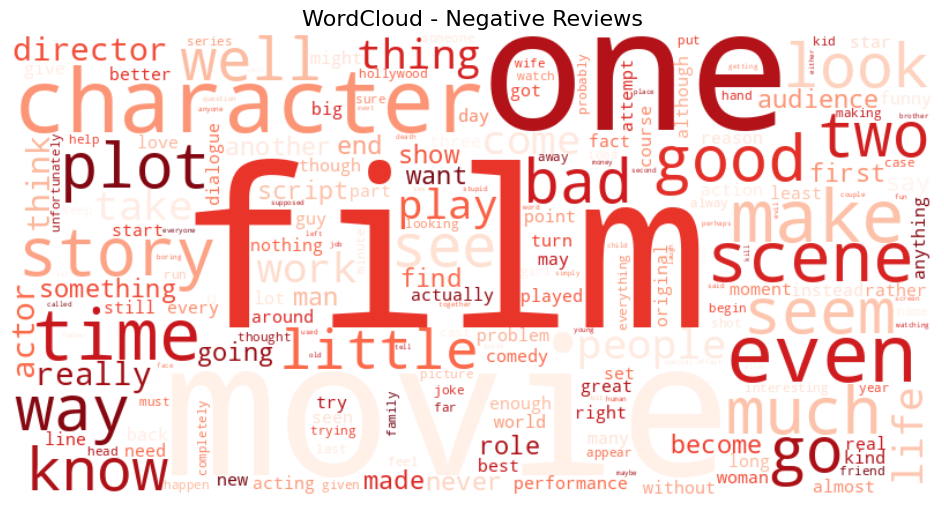

In [12]:
# Separate positive and negative reviews
pos_reviews = " ".join(df[df["label"] == "pos"]["clean_review"])
neg_reviews = " ".join(df[df["label"] == "neg"]["clean_review"])

# WordCloud for Positive Reviews
plt.figure(figsize=(12,6))
wc_pos = WordCloud(width=800, height=400, background_color="white", colormap="Greens").generate(pos_reviews)
plt.imshow(wc_pos, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud - Positive Reviews", fontsize=16)
plt.show()

# WordCloud for Negative Reviews
plt.figure(figsize=(12,6))
wc_neg = WordCloud(width=800, height=400, background_color="white", colormap="Reds").generate(neg_reviews)
plt.imshow(wc_neg, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud - Negative Reviews", fontsize=16)
plt.show()


### 8.2 Distribution of Classes

Before training, it’s important to visualize the **class distribution** (positive vs negative).  
This helps us understand if the dataset is **balanced** or **imbalanced**, which impacts the choice of evaluation metrics.


/tmp/ipython-input-562280404.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="label", data=df, palette="viridis")


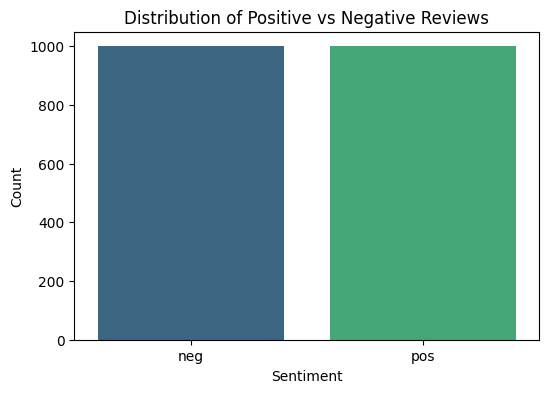

In [13]:
plt.figure(figsize=(6,4))
sns.countplot(x="label", data=df, palette="viridis")
plt.title("Distribution of Positive vs Negative Reviews")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

### 8.3 Confusion Matrix Heatmap

A **confusion matrix** helps visualize the classification results:  
- **True Positive (TP):** Correctly predicted positive reviews.  
- **True Negative (TN):** Correctly predicted negative reviews.  
- **False Positive (FP):** Negative reviews misclassified as positive.  
- **False Negative (FN):** Positive reviews misclassified as negative.  

We can plot the confusion matrix as a **heatmap** for easier interpretation.


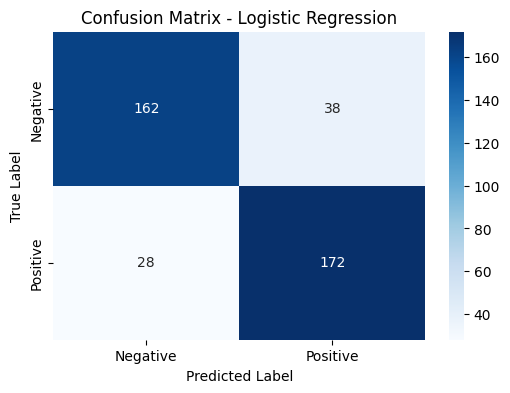

In [14]:
# Confusion Matrix for Logistic Regression
cm = confusion_matrix(y_test, lr_preds)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative","Positive"], yticklabels=["Negative","Positive"])
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


### 8.4 Top Features (Words) Important for Classification

Using **Logistic Regression**, we can inspect which words have the **highest positive** and **negative weights**.  
- Positive weights → indicate strong association with positive reviews.  
- Negative weights → indicate strong association with negative reviews.  

This gives interpretability to our model.


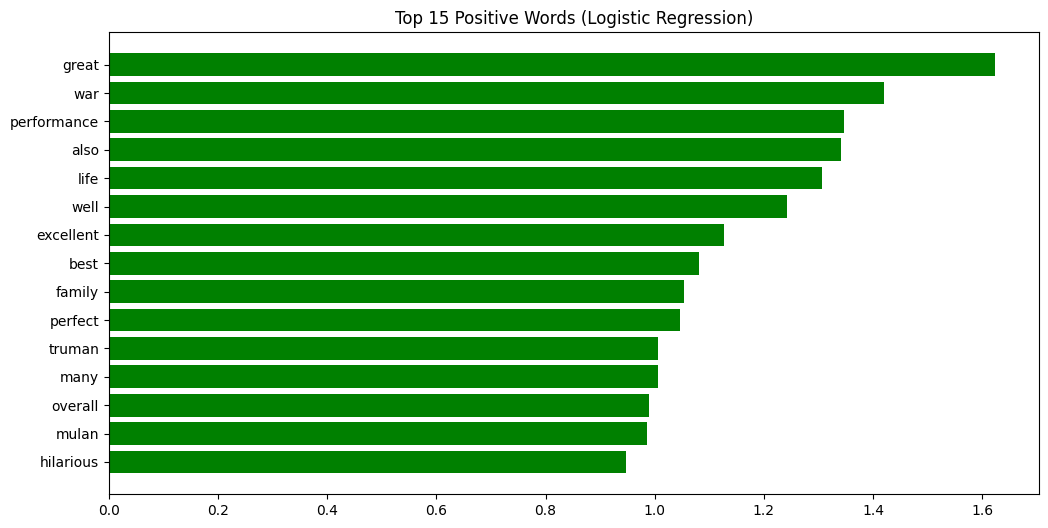

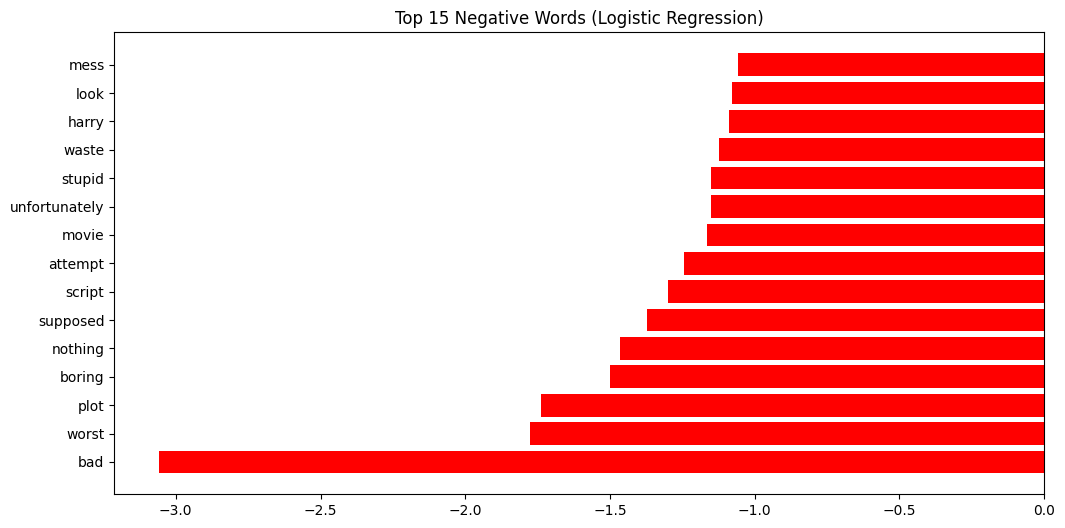

In [15]:
# Get feature names
feature_names = vectorizer.get_feature_names_out()
coeffs = lr_model.coef_[0]

# Top positive words
top_pos_idx = np.argsort(coeffs)[-15:]
top_neg_idx = np.argsort(coeffs)[:15]

plt.figure(figsize=(12,6))
plt.barh(range(15), coeffs[top_pos_idx], color="green")
plt.yticks(range(15), feature_names[top_pos_idx])
plt.title("Top 15 Positive Words (Logistic Regression)")
plt.show()

plt.figure(figsize=(12,6))
plt.barh(range(15), coeffs[top_neg_idx], color="red")
plt.yticks(range(15), feature_names[top_neg_idx])
plt.title("Top 15 Negative Words (Logistic Regression)")
plt.show()
